# CNN image recognization

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
# what is this line for?
# It is used to suppress warning messages that may clutter the output.
warnings.filterwarnings('ignore')

import os
# List all files in the input directory, why is input directory used here? answer:
# The input directory is typically used in data science and machine learning projects to store datasets that will be used for analysis or model training.
print(os.listdir("input"))

['sample_submission.csv', 'test.csv', 'train.csv']


## Loading the Data Set

In [3]:
train = pd.read_csv("input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv("input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis=1)
Y_train.unique()

array([1, 0, 4, 7, 3, 5, 8, 9, 2, 6])

label
1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: count, dtype: int64

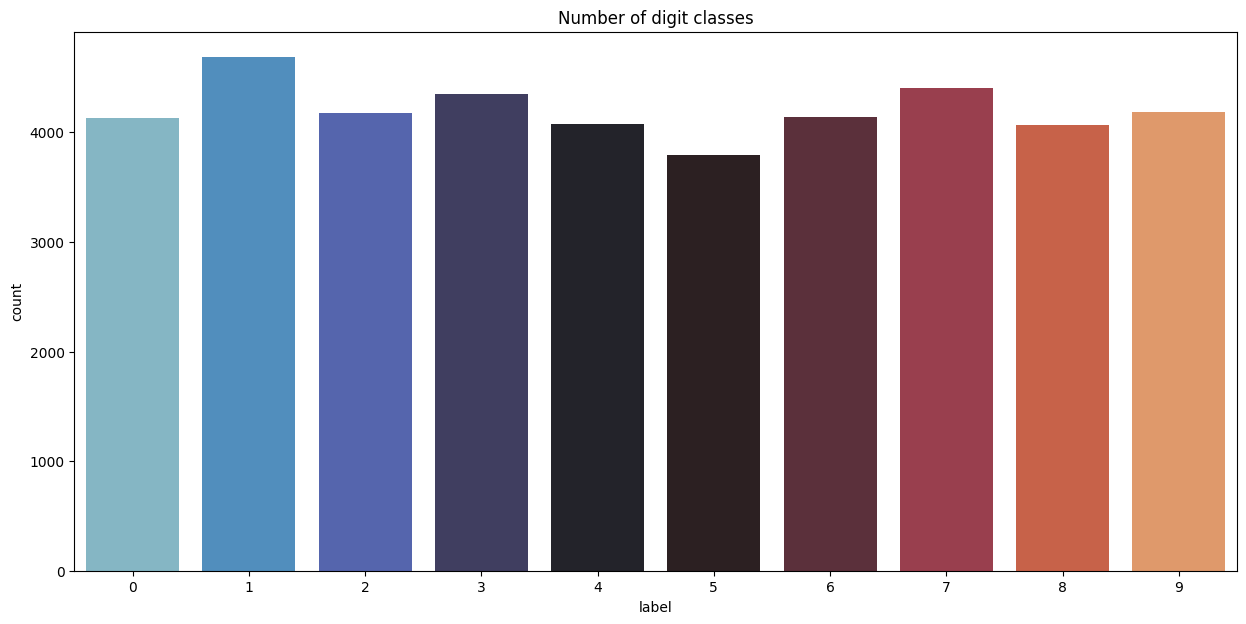

In [6]:
plt.figure(figsize=(15,7))
g = sns.countplot(x=Y_train, palette="icefire")
plt.title("Number of digit classes")
Y_train.value_counts()
# What does the countplot show?
# The countplot shows the distribution of different digit classes in the training dataset, indicating how many instances of each digit (0-9) are present.

In [7]:
print(type(X_train))
print(type(X_train.iloc[0]))
# what is iloc here?
# X_train.iloc[0] is used to access the first row of the DataFrame X_train.

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


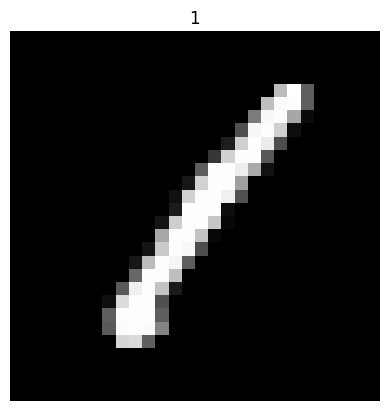

In [8]:
# how to turn a pandas Series to an image and display it?

img = X_train.iloc[0].values # type conversion from Series to ndarray
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(Y_train.iloc[0])
plt.axis("off")
plt.show()

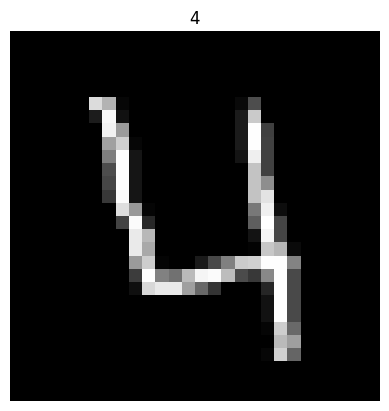

In [9]:
img = X_train.iloc[3].values
img = img.reshape((28,28))
plt.imshow(img,cmap='gray')
plt.title(Y_train.iloc[3])  
plt.axis("off")
plt.show()

## Normalization, Reshape and Label Encoding

In [10]:
X_train = X_train / 255.0
test = test / 255.0
# why divide by 255.0 here?
# Dividing by 255.0 normalizes the pixel values of the images to a range between 0 and 1, which is a common preprocessing step in image processing to improve the performance of machine learning models.
# how do i know the pixel values are between 0 and 255?
# Pixel values for grayscale images typically range from 0 (black) to 255 (white) in 8-bit images. This is a standard representation for pixel intensity in digital images.
print("X_train shape: ", X_train.shape)
print("test shape: ", test.shape)

X_train shape:  (42000, 784)
test shape:  (28000, 784)


In [11]:
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)
# why reshape to (-1,28,28,1)?
# Reshaping to (-1, 28, 28, 1) is done to prepare the data for input into a convolutional neural network (CNN). 
# The -1 allows the number of samples to be inferred automatically, 28 and 28 are the height and width of the images, and 1 indicates that the images are grayscale (single channel).
print("X_train shape: ", X_train.shape)
print("test shape: ", test.shape)

X_train shape:  (42000, 28, 28, 1)
test shape:  (28000, 28, 28, 1)


In [12]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes=10)


## Train Test Split
9:1

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=2)
print("X_train shape: ", X_train.shape)
print("X_val shape: ", X_val.shape)
print("Y_train shape: ", Y_train.shape) 
print("Y_val shape: ", Y_val.shape)

X_train shape:  (37800, 28, 28, 1)
X_val shape:  (4200, 28, 28, 1)
Y_train shape:  (37800, 10)
Y_val shape:  (4200, 10)


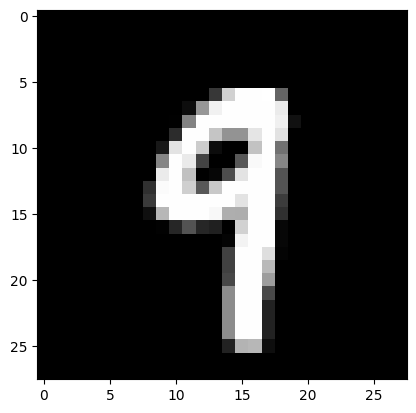

In [14]:
plt.imshow(X_train[2][:,:,0], cmap='gray')
plt.show()

## Implement With Keras

### Create Model
- conv=>max pool=>dropout=>conv=>max pool=>dropout=>fully connected(2 layers)
- Dropout: Dropout is a technique where randomly selected neurons are ignored during training

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

model = Sequential()

# first conv layer
model.add(Conv2D(filters=8, kernel_size=(5,5), padding='Same',
                 activation='relu', input_shape=(29, 28, 1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# second conv layer
# padding='Same' means that the output feature map will have the same spatial dimensions (height and width) as the input feature map by adding zero-padding around the input.
model.add(Conv2D(filters=16, kernel_size=(3,3), padding='Same',
                 activation='relu'))
# pool_size=(2,2) means that the max pooling operation will consider a 2x2 area of the input feature map and reduce it to a single value (the maximum value) for that area.
# strides=(2,2) means that the pooling window will move 2 pixels at a time both horizontally and vertically across the input feature map.
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
# Dropout is used here to prevent overfitting by randomly setting a fraction of input units to 0 during training, which helps the model generalize better to unseen data.
model.add(Dropout(0.25))


# fully connected
model.add(Flatten())
# 256 neurons in the dense layer, balanced between model complexity and computational efficiency.
# A dense layer, also known as a fully connected layer, is a layer in a neural network where each neuron is connected to every neuron in the previous layer.
# In a dense layer, each neuron has its own set of weights and biases that connect it to all the neurons in the previous layer. During the forward pass, the output of each neuron in the previous layer is multiplied by its corresponding weight, summed up, and then passed through an activation function to produce the output of the neuron in the dense layer.
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))



In [18]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 29, 28, 8)      │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 204,906 (800.41 KB)

 Trainable params: 204,906 (800.41 KB)

 Non-trainable params: 0 (0.00 B)

### Define Optimizer
- Adam optimizer: Change the learning rate

In [23]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

### Compile Model
- categorical crossentropy
- 

In [29]:
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

### Epochs and Batch Size
- Say you have a dataset of 10 examples (or samples). Youhave a batch size of 2, and you've specified you want the algirithm to run for 3 **epochs**. Therefore, in each eoch, you have 5 **batches**(10/2=5). Each batch gets passed through thealgorithm, therefore you have 5 iterations **per epoch**.

In [30]:
epochs = 10
batch_size = 250

### Data Augmentation
- To avoid overfitting problem, we need to expand rtificially our handwritten digit dataset
- Aliter the training data with small transformations to reproduce the variations of digit.
- For example, the number is not centered, thescale is not the same (some who write with big/small numbers) The image is rotated.
- ![augment](https://i.ibb.co/N6cH276/augment.jpg)

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False, # Subtracts the mean of the dataset from each sample.
        samplewise_center=False, # Subtracts the mean of each sample.
        featurewise_std_normalization=False, # Divides inputs by std of the dataset.
        samplewise_std_normalization=False, # Divides each input by its std.
        zca_whitening=False, # Applies ZCA whitening.
        rotation_range=5, # Randomly rotate images in the range (degrees, 0 to 180).
        zoom_range=0.1, # Randomly zoom image.
        height_shift_range=0.1, # Randomly shift images vertically (fraction of total height).
        width_shift_range=0.1, # Randomly shift images horizontally (fraction of total width).
        horizontal_flip=False, # Randomly flip images horizontally.
        vertical_flip=False # Randomly flip images vertically.
)

datagen.fit(X_train)

### Fit the model

In [32]:
history = model.fit(datagen.flow(X_train, Y_train, batch_size=batch_size),
                    epochs=epochs, validation_data=(X_val, Y_val),
                    steps_per_epoch=X_train.shape[0] // batch_size)

Epoch 1/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 20s 119ms/step - accuracy: 0.4336 - loss: 1.6235 - val_accuracy: 0.9362 - val_loss: 0.2479
Epoch 2/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7760 - loss: 0.7329 - val_accuracy: 0.9374 - val_loss: 0.2456
Epoch 3/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step - accuracy: 0.8408 - loss: 0.4931 - val_accuracy: 0.9650 - val_loss: 0.1242
Epoch 4/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8600 - loss: 0.4137 - val_accuracy: 0.9645 - val_loss: 0.1246
Epoch 5/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 18s 122ms/step - accuracy: 0.8938 - loss: 0.3424 - val_accuracy: 0.9702 - val_loss: 0.0989
Epoch 6/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9280 - loss: 0.2275 - val_accuracy: 0.9712 - val_loss: 0.0988
Epoch 7/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 19s 127ms/step - accuracy: 0.9107 - loss: 0.2783 - val_accuracy: 0.9724 - val_loss: 0.0868
Epoch 8/10
151/151 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9240 - loss: 0.2731 - val_

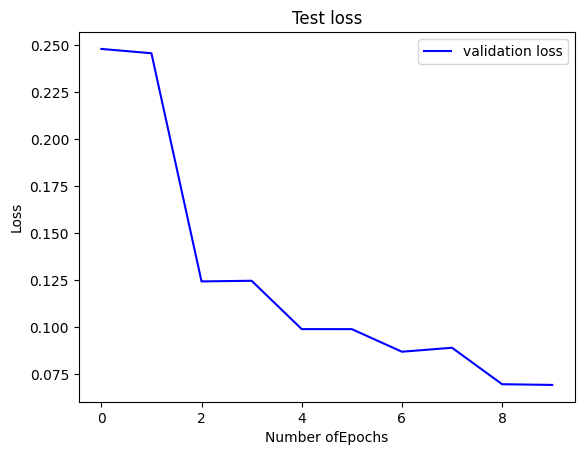

In [33]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test loss")
plt.xlabel("Number ofEpochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


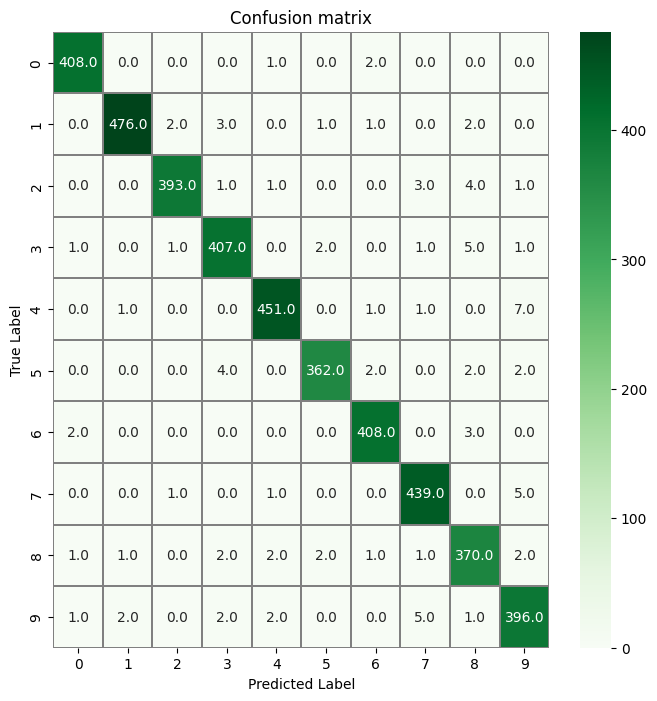

In [34]:
import seaborn as sns
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis=1)
Y_true = np.argmax(Y_val, axis=1)
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens",linecolor="gray", fmt='.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion matrix")
plt.show()